In [1]:
# import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random as rand
import pickle
from scipy import stats
import time


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


rand.seed(123)
np.random.seed(123)

In [2]:
def f(count_stat):
    Z = []

    for x in range(9):
        temp_grid = []
        for y in range(9):
            #print(f"({x},{y})")
            temp_grid.append(np.sum(count_stat[0][y][8-x]))
            
        #print(temp_grid)
        Z.append(temp_grid)
    return np.array(Z)

In [3]:
n_trials = 1 #

n_trajectories = 500

bootstrap = 0
n_constraints = 3

threshold1 = 200 # 
threshold2 = 0.95 # 
threshold3 = 0.1
list_threshold3 = [0.1, 0.3, 0.6, 0.9] # try with 0.9 or 1.0 / myopic and non-myopic S1
threshold4 = 200 # 


df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df7 = pd.DataFrame()

Iteration 0
[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
{'blue': [], 'green': [], 'cs': array([43,  4, 40]), 'ca': [DOWN_LEFT, RIGHT]}
[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}


/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:89: RuntimeWarning: invalid value encountered in long_scalars
  dict_mca['avg_time'] = time_s2 / usage_s2
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:91: RuntimeWarning: invalid value encountered in double_scalars
  dict_mca['avg_reward'] = reward_s2 / usage_s2
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:303: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  action_thresholds[1] = expected_avg_reward / current_reward
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:72: RuntimeWarning: invalid value encountered in long_scalars
  dict_mca['avg_time'] = time_s1 / usage_s1
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:74: RuntimeWarning: invalid value encountered in double

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11c2939b0>}
Total time: 947279


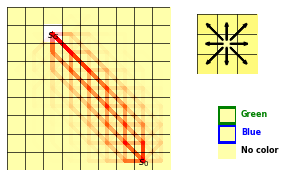

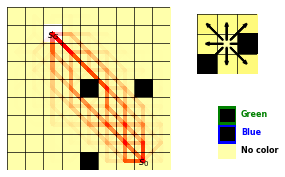

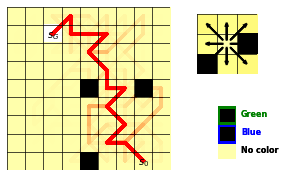

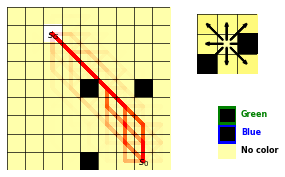

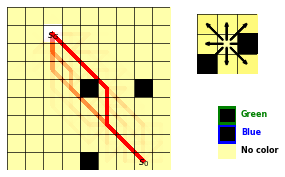

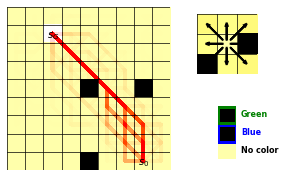

In [4]:

time_tot = int(round(time.time() * 1000))

df = pd.DataFrame()
js_div = pd.DataFrame()
mca = []

for i in range(n_trials):
    print(f"Iteration {i}")
    #generate constraints
    blue, green, cs, ca, start, goal = generate_constraints(9, n_constraints=n_constraints)
    constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    '''blue = [21,  9, 59,  1,  0, 20]
    green = [42, 18, 76, 41, 23, 30]
    cs = [63, 74, 13, 39, 48, 38]
    ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]'''
    start =7
    goal = 65
    
    #generate nomminal 
    time_exp = int(round(time.time() * 1000))
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal, n_trajectories=n_trajectories)
    time_exp = int(round(time.time() * 1000)) - time_exp 
    temp_matrix = count_states(demo_n.trajectories, n_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='nominal')
    temp_dict['time'] = time_exp / n_trajectories
    df = pd.concat([df, temp_dict])
    
    Z_distr = f(temp_matrix)
    Z_distr = np.array(Z_distr)
    Z_distr = Z_distr + 1E-3
    Z_distr[8-int(start/9)][int(start%9)]=0
    Z_distr[8-int(goal/9)][int(goal%9)] = 0

    #plt.imshow(Z_distr/np.sum(Z_distr), cmap='hot', interpolation='nearest')
    #plt.show()

    #Z_distr/np.sum(Z_distr)
    distr = np.array(Z_distr/np.sum(Z_distr))
    
    new_distr = []
    for i in range(len(distr)):
        new_distr.append(distr[len(distr)-i-1])

    new_distr = np.array(new_distr)


    cs = np.random.choice(np.arange(0,81), replace=False, p = new_distr.flatten(), size = n_constraints)
    constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    print(constraints)
    #exit()
    
    #generate constrained grid
    cc = [1, 2]
    time_exp = int(round(time.time() * 1000))
    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True, n_trajectories=n_trajectories)
    time_exp = int(round(time.time() * 1000)) - time_exp 
    temp_matrix = count_states(demo_c.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='const')
    temp_dict['time'] = time_exp / n_trajectories
    df = pd.concat([df, temp_dict])
    
    
    s1_noMyopic = System1Solver(myopic=False)
    mca_s1_nb_noMyopic = MCA(n=n, c=c, s1=s1_noMyopic, demo=None, only_s1=True)
    demo_mca_s1_nb_noMyopic = mca_s1_nb_noMyopic.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1_nb_noMyopic = count_states(demo_mca_s1_nb_noMyopic.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1_nb_noMyopic, type_mca='S1 noMyopic', agent=mca_s1_nb_noMyopic, s1_usage=mca_s1_nb_noMyopic.getStatistics()[0])
    #f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1_nb_noMyopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])

    s1_Myopic = System1Solver(myopic=False)
    mca_s1_nb_Myopic = MCA(n=n, c=c, s1=s1_Myopic, demo=None, only_s1=True)
    demo_mca_s1_nb_Myopic = mca_s1_nb_Myopic.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1_nb_Myopic = count_states(demo_mca_s1_nb_Myopic.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1_nb_Myopic, type_mca='S1 Myopic', agent=mca_s1_nb_Myopic, s1_usage=mca_s1_nb_Myopic.getStatistics()[0])
    #f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1_nb_Myopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])

    mca_s2 = MCA(n=n, c=c, demo=None, threshold5=1, only_s2=True)
    demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s2, type_mca='S2', agent=mca_s2 )
    #f1 = G.plot_world(f'Only S2', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s2, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])

    for threshold3 in list_threshold3:
        mca_01_myopic = MCA(n=n, c=c, s1=s1_Myopic, demo=None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5=1)	
        demo_mca_01_myopic = mca_01_myopic.generate_trajectories(n_trajectories)
        temp_matrix_mca_01_myopic = count_states(demo_mca_01_myopic.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
        temp_dict=build_dict(temp_matrix_mca_01_myopic, type_mca='SOFAI w/ Myopic S1', agent=mca_01_myopic, t3= threshold3)
        #f1 = G.plot_world(f'SOFAI_myopic', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_01_myopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
        df = pd.concat([df, temp_dict])

        mca_01_noMyopic = MCA(n=n, c=c, s1=s1_noMyopic, demo=None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5=1)	
        demo_mca_01_noMyopic = mca_01_noMyopic.generate_trajectories(n_trajectories)
        temp_matrix_mca_01_noMyopic = count_states(demo_mca_01_noMyopic.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
        temp_dict=build_dict(temp_matrix_mca_01_noMyopic, type_mca='SOFAI w/ no Myopic S1', agent=mca_01_noMyopic, t3= threshold3 )
        #f1 = G.plot_world(f'SOFAI_noMyopic', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_01_noMyopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
        df = pd.concat([df, temp_dict])

        temp_jsdiv = {}
        temp_jsdiv['t3'] = threshold3
        temp_jsdiv['t4'] = threshold4
        temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_s1_nb_noMyopic.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s1_nb_noMyopic.modelSelf.ntra_per_transition + 1E-10))
        temp_jsdiv['type'] = 'S1 no Myopic'
        temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
        js_div = pd.concat([js_div, temp_jsdiv])

        temp_jsdiv = {}
        temp_jsdiv['t3'] = threshold3
        temp_jsdiv['t4'] = threshold4
        temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_s1_nb_Myopic.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s1_nb_Myopic.modelSelf.ntra_per_transition + 1E-10))
        temp_jsdiv['type'] = 'S1 Myopic'
        temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
        js_div = pd.concat([js_div, temp_jsdiv])

        temp_jsdiv = {}
        temp_jsdiv['t3'] = threshold3
        temp_jsdiv['t4'] = threshold4
        temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_01_myopic.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_01_myopic.modelSelf.ntra_per_transition + 1E-10))
        temp_jsdiv['type'] = 'SOFAI w/ Myopic S1'
        temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
        js_div = pd.concat([js_div, temp_jsdiv])

        temp_jsdiv = {}
        temp_jsdiv['t3'] = threshold3
        temp_jsdiv['t4'] = threshold4
        temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_01_noMyopic.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_01_noMyopic.modelSelf.ntra_per_transition + 1E-10))
        temp_jsdiv['type'] = 'SOFAI w/ no Myopic S1'
        temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
        js_div = pd.concat([js_div, temp_jsdiv])
    
    
    time_exp = int(round(time.time() * 1000))

    
f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1_nb_noMyopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1_nb_Myopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
f1 = G.plot_world(f'Only S2', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s2, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
f1 = G.plot_world(f'SOFAI_myopic', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_01_myopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
f1 = G.plot_world(f'SOFAI_noMyopic', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_01_noMyopic, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

time_tot = int(round(time.time() * 1000)) - time_tot
print(f"Total time: {time_tot}")


In [5]:
#df = pd.read_csv('remaining_time/same_grid/risk0.8/dati_myopic_nomyopic_risk_0.8.csv')
#df

In [6]:

'''label='length'
list_df = [df3[label],df4[label]]
list_mean=[(np.mean(x)+np.std(x))*1.1 for x in list_df]

print(np.max(list_mean))
'''
'''def min_max(label, df, df2, df3, df4, df7):
    list_df = [df[label],df2[label],df3[label],df4[label],df7[label]]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label'''

def min_max(label, df):
    list_df = df[label]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    #print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label

In [7]:
df.loc[df['type']=='const']

traj_n  length     reward   time sub_type  time_agent  avg_time  \
0       0   10.08 -39.455592  3.394     null           0       0.0   

   reward_agent  avg_reward  usage  ...     Reward   Viol  S1_Usage   t1   t2  \
0           0.0         0.0      0  ... -39.455592  0.044       0.0  200  0.8   

    t3  t4  t6   t7  perc_usage  
0  0.0   0   1  0.5         NaN  

[1 rows x 22 columns]

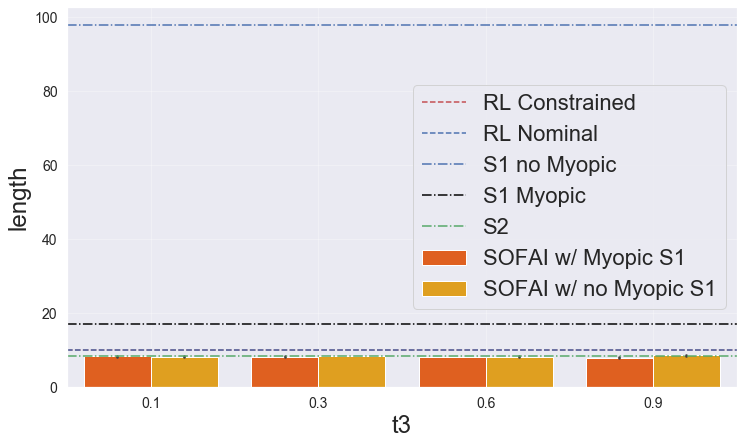

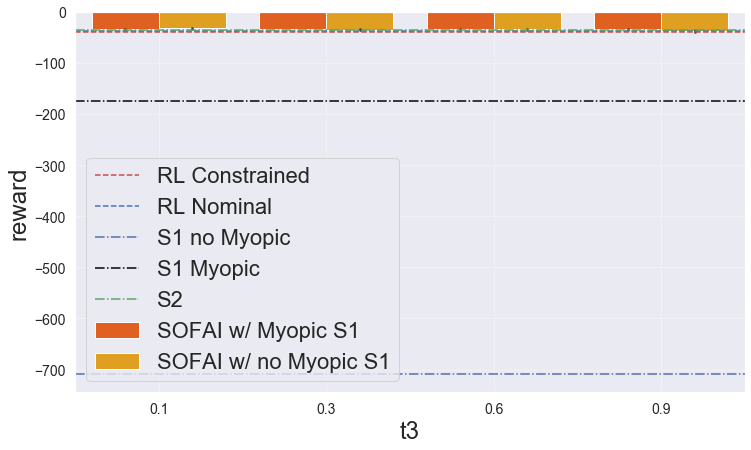

ok


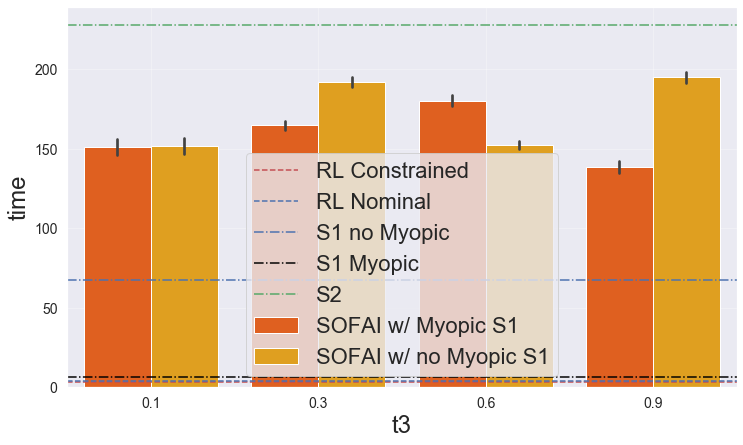

In [8]:
#temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==threshold3) | (df['type']=='S1 noMyopic') | (df['type']=='S2') | (df['type']=='nominal')| (df['type']=='const')]
temp_df = df
#temp_df = temp_df.rename(columns={"01": "SOFAI-01", "s1": "S1-SOFAI"})

label_x = 't3'
label='length'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='reward'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='time'
min_label, max_label = min_max(label, df)
print("ok")
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

#label='S1_Usage'
#min_label, max_label = min_max(label, df, df2, df3, df4, df7)
#plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

In [9]:
#df3.loc[(df3['type']=='02') & (df3['t3']==0.4)& (df3['t4']==0)]
df

traj_n  length       reward     time sub_type  time_agent   avg_time  \
0         0  10.122   -37.834492    3.692     null           0   0.000000   
0         0  10.080   -39.455592    3.394     null           0   0.000000   
0         0  58.000 -1008.793939    2.000       s1           2   0.034483   
0         0  58.000 -1008.793939    2.000       s2           0        NaN   
1         1  53.000  -850.107648    6.000       s1           6   0.113208   
..      ...     ...          ...      ...      ...         ...        ...   
497     497   7.000   -26.284271  148.000       s2         148  21.142857   
498     498   9.000   -35.941125  196.000       s1           0        NaN   
498     498   9.000   -35.941125  196.000       s2         196  21.777778   
499     499   7.000   -26.284271  136.000       s1           0        NaN   
499     499   7.000   -26.284271  136.000       s2         136  19.428571   

     reward_agent  avg_reward  usage  ...      Reward   Viol  S1_Usage   t1  \
0        0.000000    0.000000      0  ...  -37.834492  1.218       0.0  200   
0        0.000000    0.000000      0  ...  -39.455592  0.044       0.0  200   
0    -1008.793939  -17.392999     58  ... -709.153199  5.712       1.0  200   
0        0.000000         NaN      0  ... -709.153199  5.712       1.0  200   
1     -850.107648  -16.039767     53  ... -709.153199  5.712       1.0  200   
..            ...         ...    ...  ...         ...    ...       ...  ...   
497    -26.284271   -3.754896      7  ...  -37.652036  0.104       0.0  200   
498      0.000000         NaN      0  ...  -37.652036  0.104       0.0  200   
498    -35.941125   -3.993458      9  ...  -37.652036  0.104       0.0  200   
499      0.000000         NaN      0  ...  -37.652036  0.104       0.0  200   
499    -26.284271   -3.754896      7  ...  -37.652036  0.104       0.0  200   

      t2   t3  t4  t6   t7  perc_usage  
0    0.8  0.0   0   1  0.5         NaN  
0    0.8  0.0   0   1  0.5         NaN  
0    0.8  0.0   0   1  0.5         1.0  
0    0.8  0.0   0   1  0.5         0.0  
1    0.8  0.0   0   1  0.5         1.0  
..   ...  ...  ..  ..  ...         ...  
497  0.8  0.9   0   1  0.5         1.0  
498  0.8  0.9   0   1  0.5         0.0  
498  0.8  0.9   0   1  0.5         1.0  
499  0.8  0.9   0   1  0.5         0.0  
499  0.8  0.9   0   1  0.5         1.0  

[11002 rows x 22 columns]

In [10]:
df.type

0                    nominal
0                      const
0                S1 noMyopic
0                S1 noMyopic
1                S1 noMyopic
               ...          
497    SOFAI w/ no Myopic S1
498    SOFAI w/ no Myopic S1
498    SOFAI w/ no Myopic S1
499    SOFAI w/ no Myopic S1
499    SOFAI w/ no Myopic S1
Name: type, Length: 11002, dtype: object

In [11]:
def print_results(df, type_agent):
    print(f"{type_agent}: -> Length: {np.mean(df['length']):6.2f} \
 ({np.mean(df.loc[(df['sub_type']=='s1')]['usage']):6.2f} ; {np.mean(df.loc[(df['sub_type']=='s2')]['usage']):6.2f}) \
 Rew: {np.mean(df['reward']):10.4f} ({np.nanmean(df.loc[(df['sub_type']=='s1')]['avg_reward']):6.2f} ; {np.nanmean(df.loc[(df['sub_type']=='s2')]['avg_reward']):6.2f}) \
 Time: {np.mean(df['time']):10.4f} ({np.mean(df.loc[(df['sub_type']=='s1')]['avg_time']):6.4f} ; {np.mean(df.loc[(df['sub_type']=='s2')]['avg_time']):6.4f})")

#df3.loc[(df3['traj_n']>=0) & (df3['t4']==0) & (df3['t3']==0.4) & (df3['type']=='const')]
temp_df = df.loc[df['type']=='const']
print_results(temp_df,'RL')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['type']=='SOFAI w/ Myopic S1')]
print_results(temp_df,'01 M.')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['type']=='SOFAI w/ no Myopic S1')]
print_results(temp_df,'01 noM.')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['type']=='S1 noMyopic')]
print_results(temp_df,'S1 noM.')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['type']=='S1 Myopic')]
print_results(temp_df,'S1 M.')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['type']=='S2')]
print_results(temp_df,'S2')



temp_df = df

RL: -> Length:  10.08  (   nan ;    nan)  Rew:   -39.4556 (   nan ;    nan)  Time:     3.3940 (   nan ;    nan)
01 M.: -> Length:   8.20  (  1.69 ;   6.51)  Rew:   -33.9438 ( -4.60 ;  -3.97)  Time:   158.6975 (0.3510 ; 25.5300)
01 noM.: -> Length:   8.37  (  1.26 ;   7.11)  Rew:   -34.6871 ( -4.42 ;  -4.08)  Time:   172.7975 (0.3194 ; 25.6195)
S1 noM.: -> Length:  97.82  ( 97.82 ;   0.00)  Rew:  -709.1532 ( -8.26 ;    nan)  Time:    67.4380 (0.6327 ;    nan)
S1 M.: -> Length:  17.05  ( 17.05 ;   0.00)  Rew:  -174.4695 ( -9.46 ;    nan)  Time:     6.3740 (0.3817 ;    nan)
S2: -> Length:   8.42  (  0.00 ;   8.42)  Rew:   -35.0358 (   nan ;  -4.10)  Time:   227.9080 (   nan ; 26.9842)


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [12]:
df.to_csv("dati_myopic_nomyopic"+"_risk_"+str(threshold3)+".csv")
js_div.to_csv("jsdiv_myopic_nomyopic"+"_risk_"+str(threshold3)+".csv")
#pd.read_csv("dati_new_10grid_t1_100.csv")

In [13]:
def plot_subtype(x, y, df, hue, title, filename, min_label=0, max_label=None, list_threshold3= None):
    
    print(f"{[min_label, max_label]}")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    
    fig = plt.figure(figsize=(25, 30))
    # grid for pairs of subplots
    rows = len(list_threshold3)
    cols = 2
    grid = plt.GridSpec(rows, cols)

    #figure, axis = plt.subplots(len(list_threshold3), 2, figsize=(25, 30))
    #plt.tight_layout()
    #print(axis)

    #for index, t3, sub_plot in enumerate(list_threshold3,axis):
    for i in range(rows):
        
        t3 = list_threshold3[i]
        # create fake subplot just to title set of subplots
        fake = fig.add_subplot(grid[i, :])
        # '\n' is important
        fake.set_title(f'{title+str(t3)}\n', fontweight='semibold')
        fake.set_axis_off()
        
        # create subgrid for two subplots without space between them
        # <https://matplotlib.org/2.0.2/users/gridspec.html>
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i, :])

        # real subplot #1
        ax = fig.add_subplot(gs[0])
        ax.set_title(f'Myopic')
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ Myopic S1') )  ] #| (df['type']=='s1_nb') 
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        #axis[0,0].set_title('Myopic')

        # real subplot #2
        ax = fig.add_subplot(gs[1], sharey=ax)
        ax.set_title(f'No Myopic')
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) &  ((df['type']=='SOFAI w/ no Myopic S1') )  ] #| (df['type']=='s1_nb') 

        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        #axis[0,1].set_title('No Myopic')

    plt.savefig(filename+'.pdf')
    plt.show()

def plot_type(x, y, df, hue, title, filename, min_label=0, max_label=None, list_threshold3= None):
            
    #print(f"{[min_label, max_label]}")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    
    fig = plt.figure(figsize=(25, 30))
    # grid for pairs of subplots
    rows = len(list_threshold3)
    cols = 2
    grid = plt.GridSpec(rows, cols)
    #print(df['type'])

    #figure, axis = plt.subplots(len(list_threshold3), 2, figsize=(25, 30))
    #plt.tight_layout()
    #print(axis)

    #for index, t3, sub_plot in enumerate(list_threshold3,axis):
    for i in range(rows):
        
        t3 = list_threshold3[i]
        # create fake subplot just to title set of subplots
        fake = fig.add_subplot(grid[i, :])
        # '\n' is important
        fake.set_title(f'{title+str(t3)}\n', fontweight='semibold')
        fake.set_axis_off()
        
        # create subgrid for two subplots without space between them
        # <https://matplotlib.org/2.0.2/users/gridspec.html>
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i, :])

        # real subplot #1
        ax = fig.add_subplot(gs[0])
        ax.set_title(f'Myopic')
        temp_df = df.loc[(df['traj_n']>=0) & (((df['t3']==t3) & (df['type']!='SOFAI w/ no Myopic S1')) | (df['t3']==0))] #| (df['type']=='s1_nb') 
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        #axis[0,0].set_title('Myopic')

        # real subplot #2
        ax = fig.add_subplot(gs[1], sharey=ax)
        ax.set_title(f'No Myopic')
        temp_df = df.loc[(df['traj_n']>=0) & (((df['t3']==t3) & (df['type']!='SOFAI w/ Myopic S1')) | (df['t3']==0))] #| (df['type']=='s1_nb') 

        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        #axis[0,1].set_title('No Myopic')

    plt.savefig(filename+'.pdf')
    plt.show()



[-15, 0]


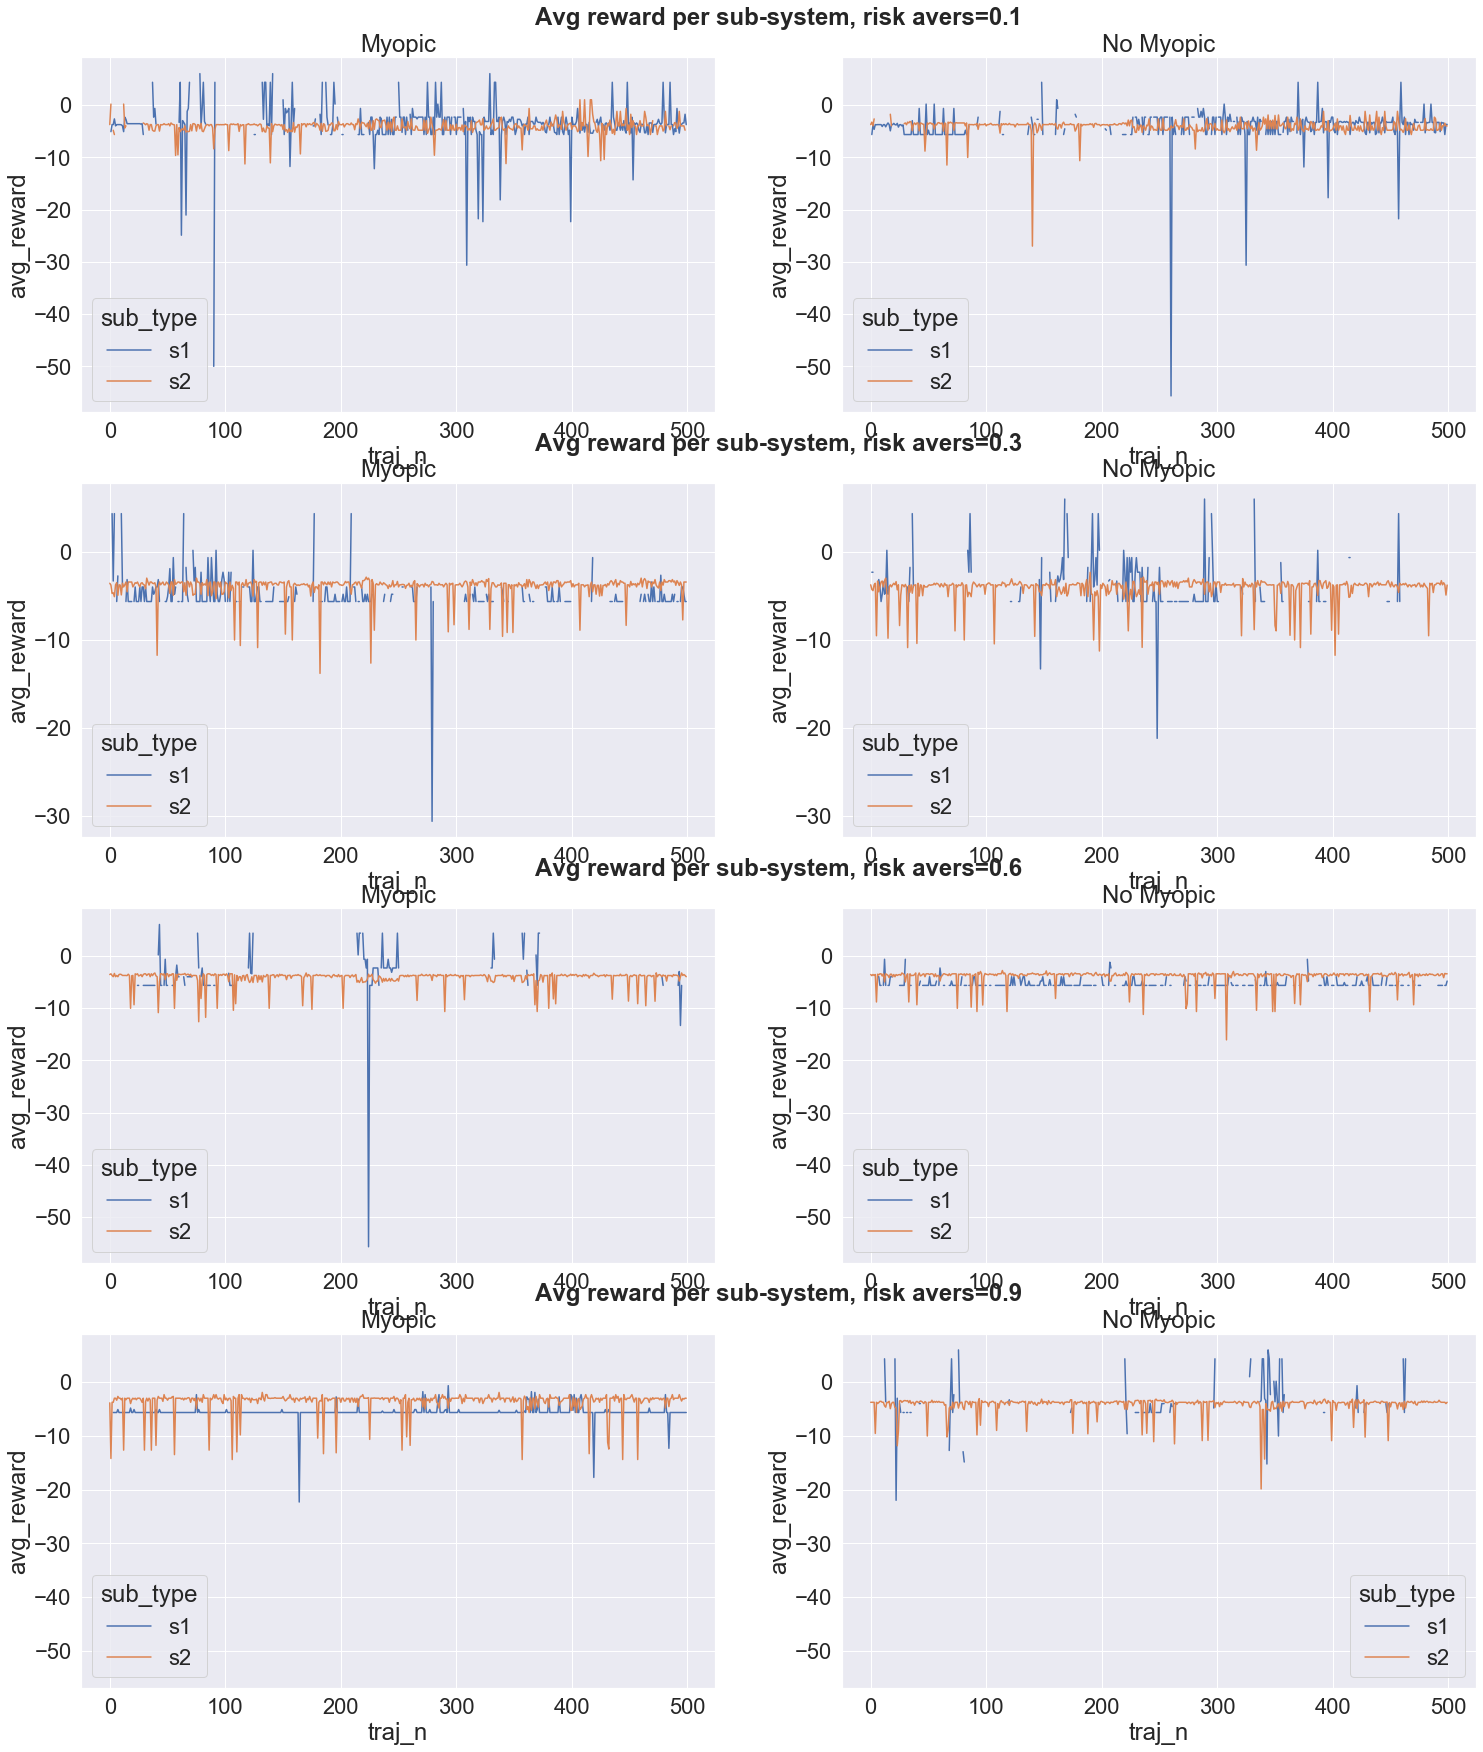

In [14]:
x='traj_n'
y='avg_reward'
#y='avg_time'
filename = y+'_risk_'
title="Avg reward per sub-system, risk avers="

plot_subtype(x,y,df, "sub_type",title,filename,  min_label= -15,  max_label=0, list_threshold3=list_threshold3)


[0, None]


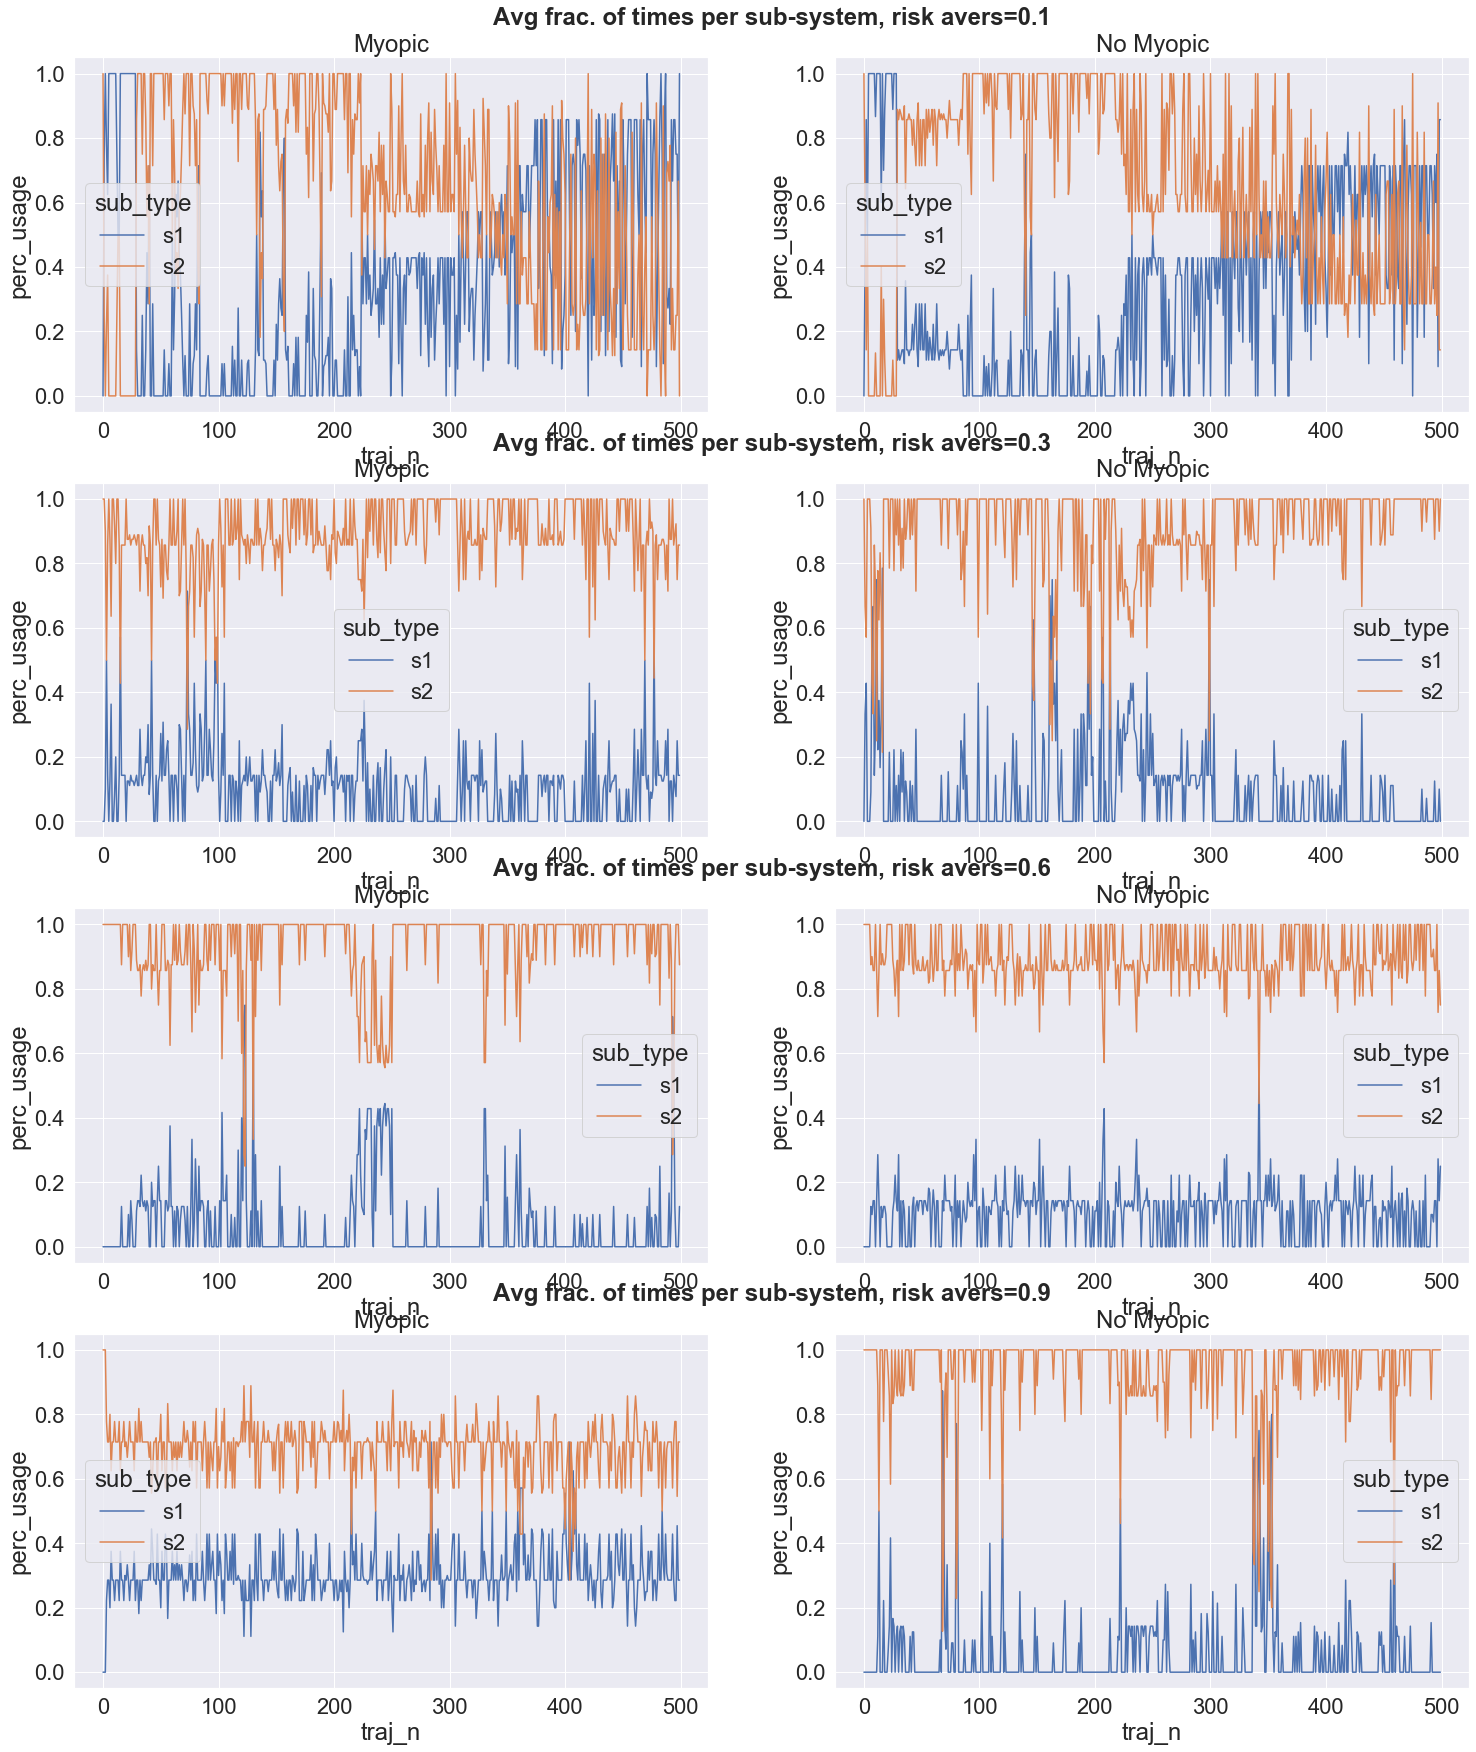

[0, None]


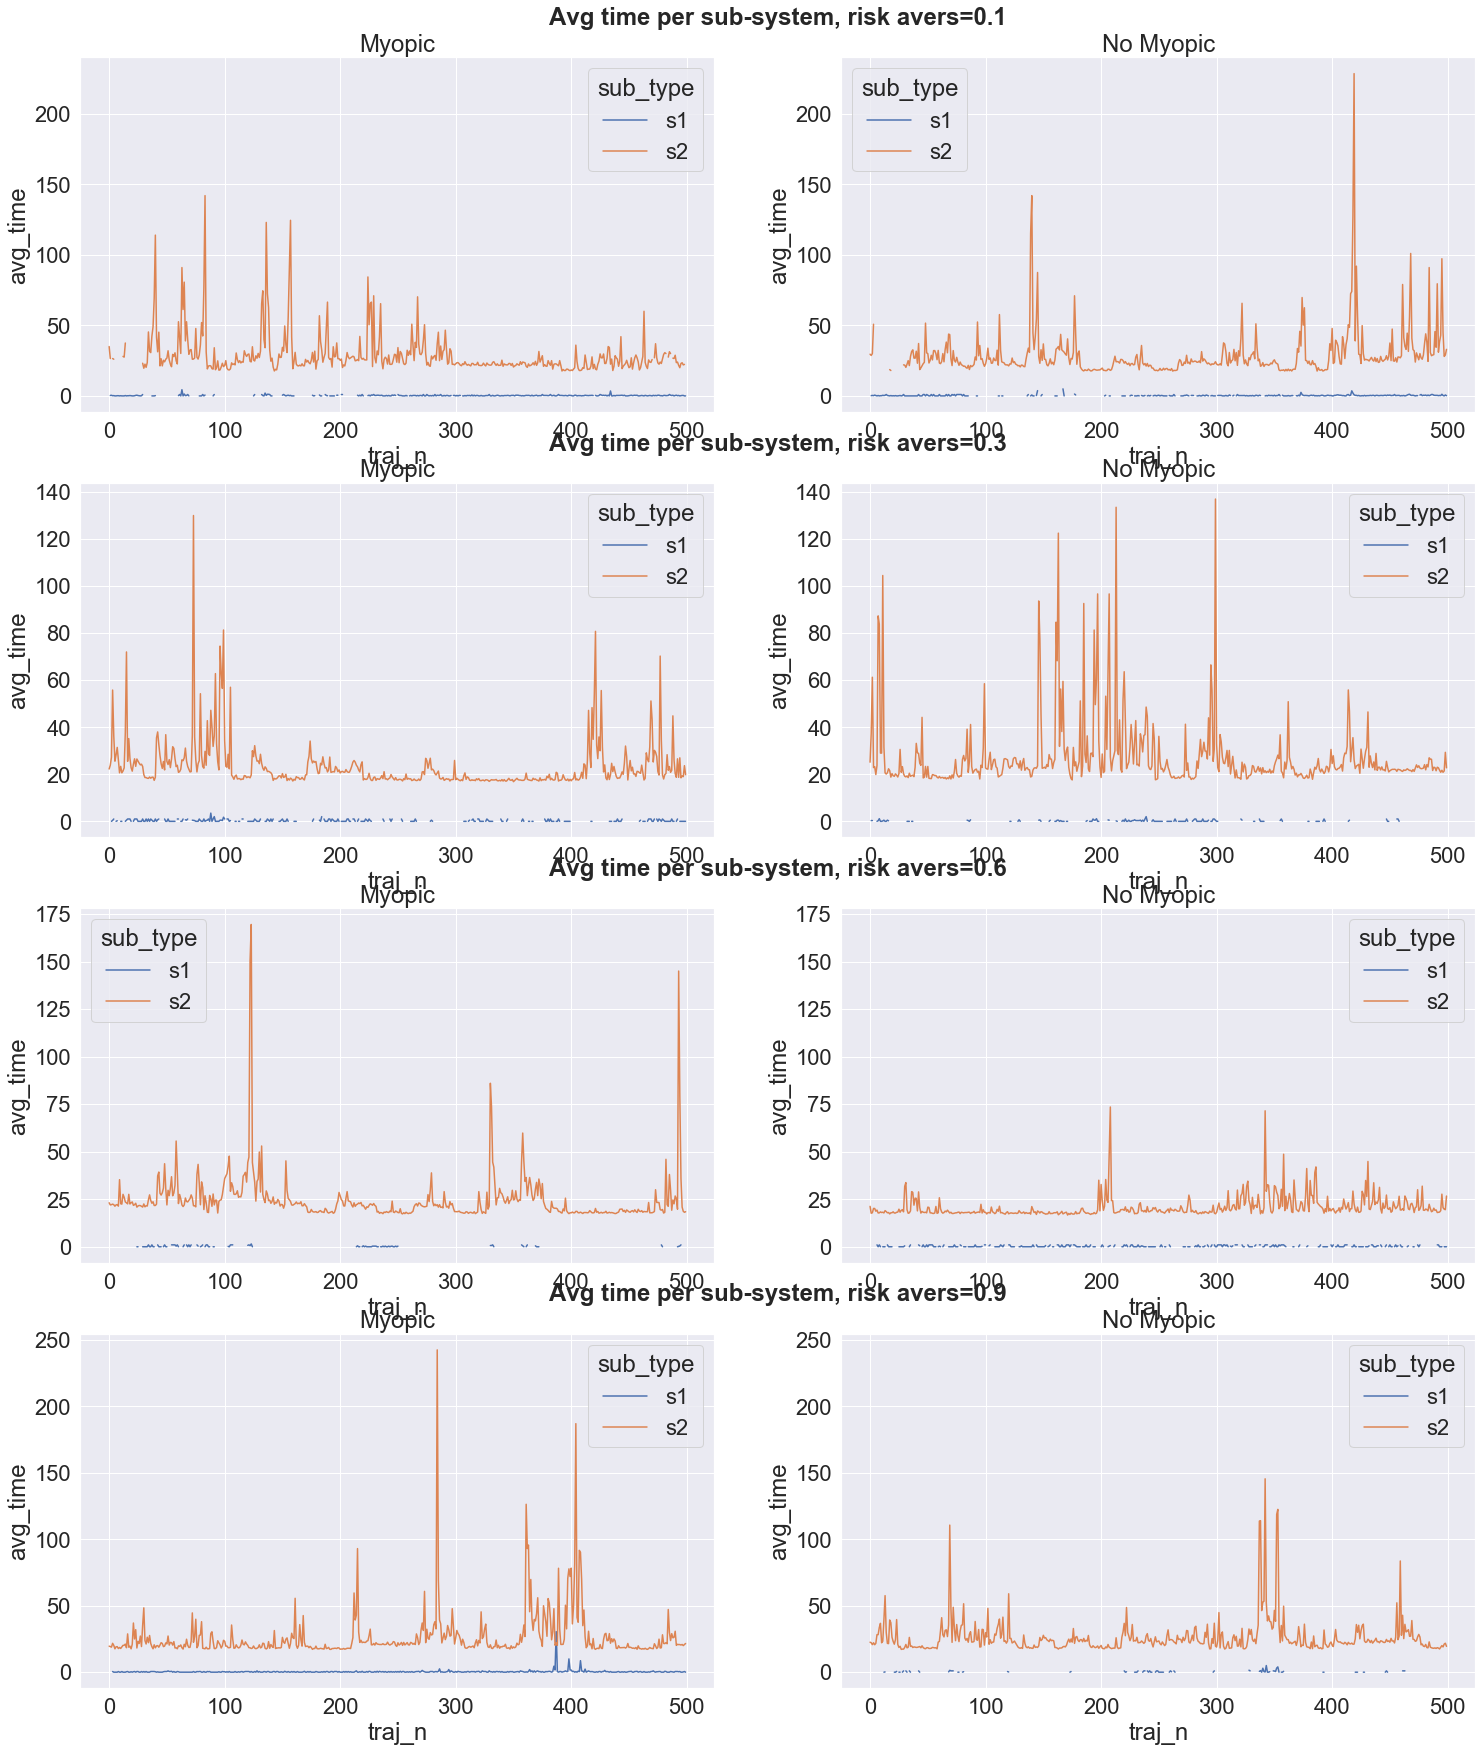

In [15]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]


x='traj_n'
y='perc_usage'
#y='avg_reward'
#y='avg_time'
filename = y+'_risk'
title="Avg frac. of times per sub-system, risk avers="

plot_subtype(x,y,df,"sub_type",title,filename, list_threshold3=list_threshold3)


x='traj_n'
y='avg_time'
filename = y+'_time'
title="Avg time per sub-system, risk avers="

plot_subtype(x,y,df, "sub_type",title,filename, list_threshold3=list_threshold3)



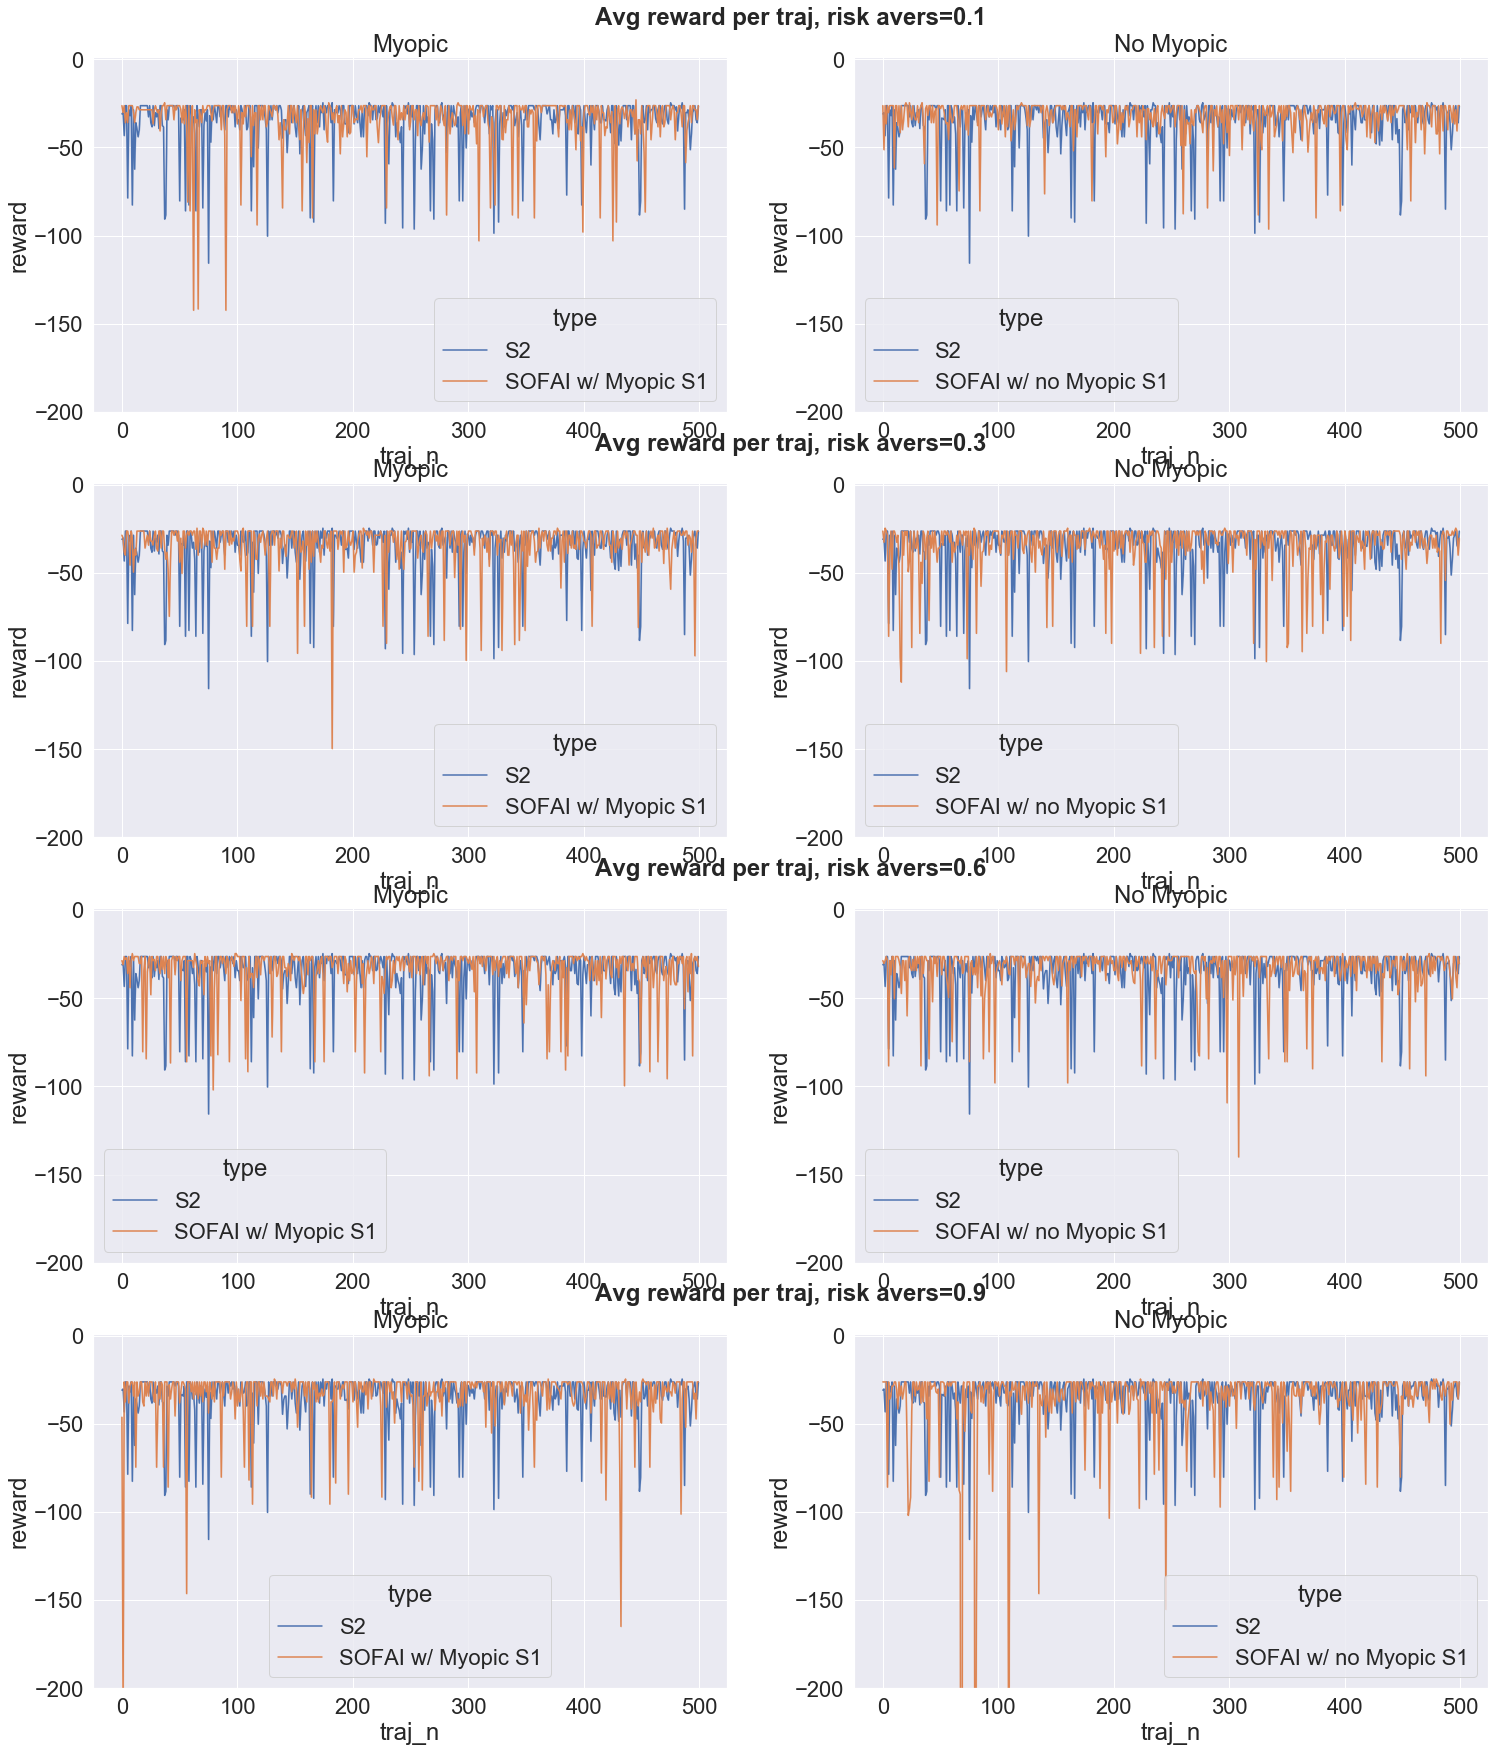

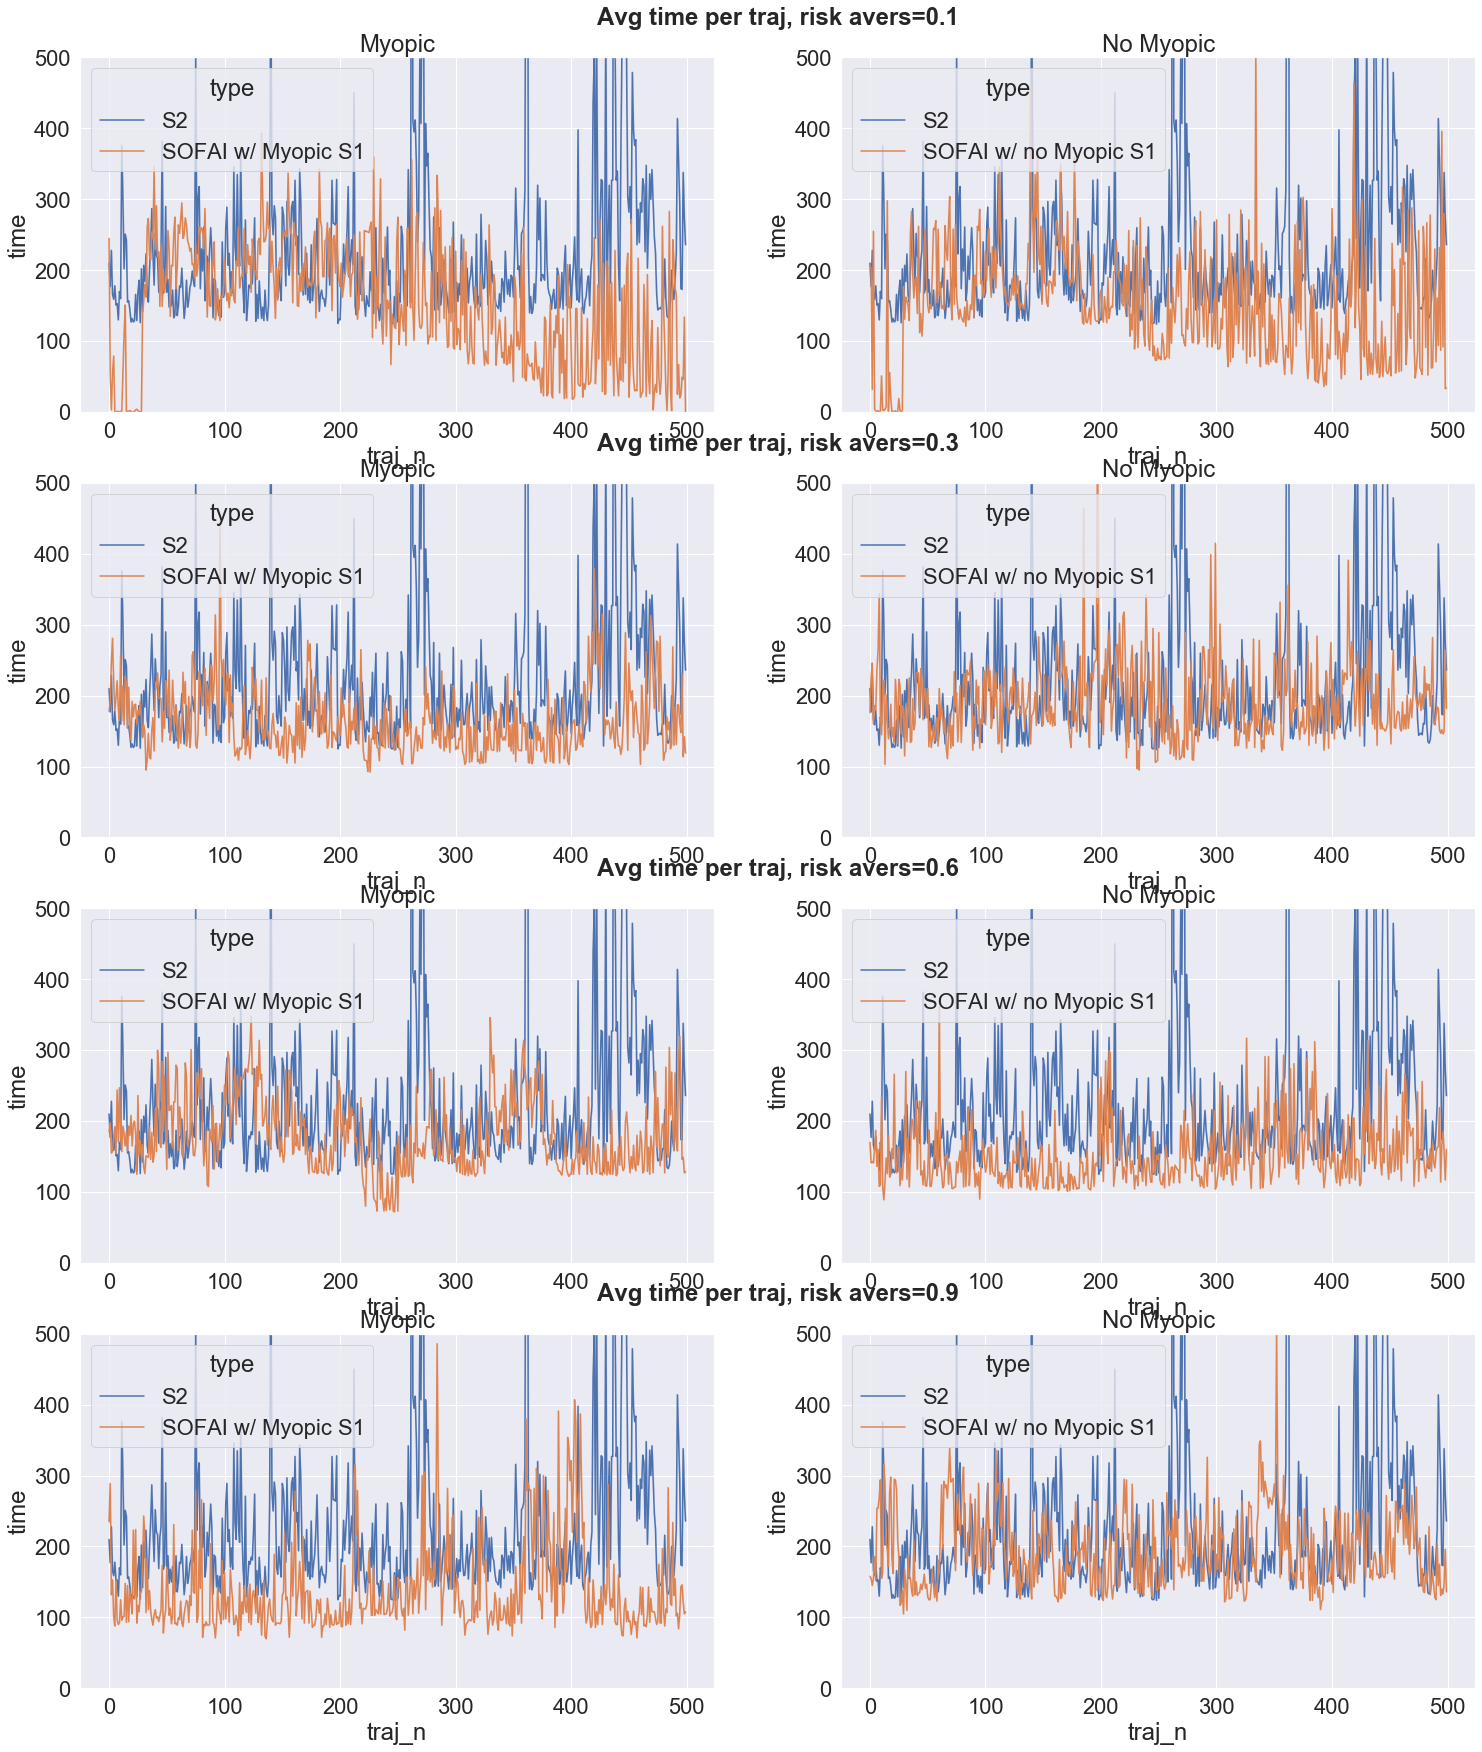

In [16]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]
#temp_df = df.loc[(df['traj_n']>=0) & ((df['type']=='01') )  ] #| (df['type']=='s1_nb') 

#print(temp_df)

x='traj_n'
#y='perc_usage'
y='reward'
#y='time'


filename = 'avg_reward_per_traj'
title="Avg reward per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=1, min_label=-200)
#plot_subtype(x,y,temp_df, "type",title,filename, list_threshold3=list_threshold3)


y='time'

filename = 'avg_time_per_traj'
title="Avg time per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=500)



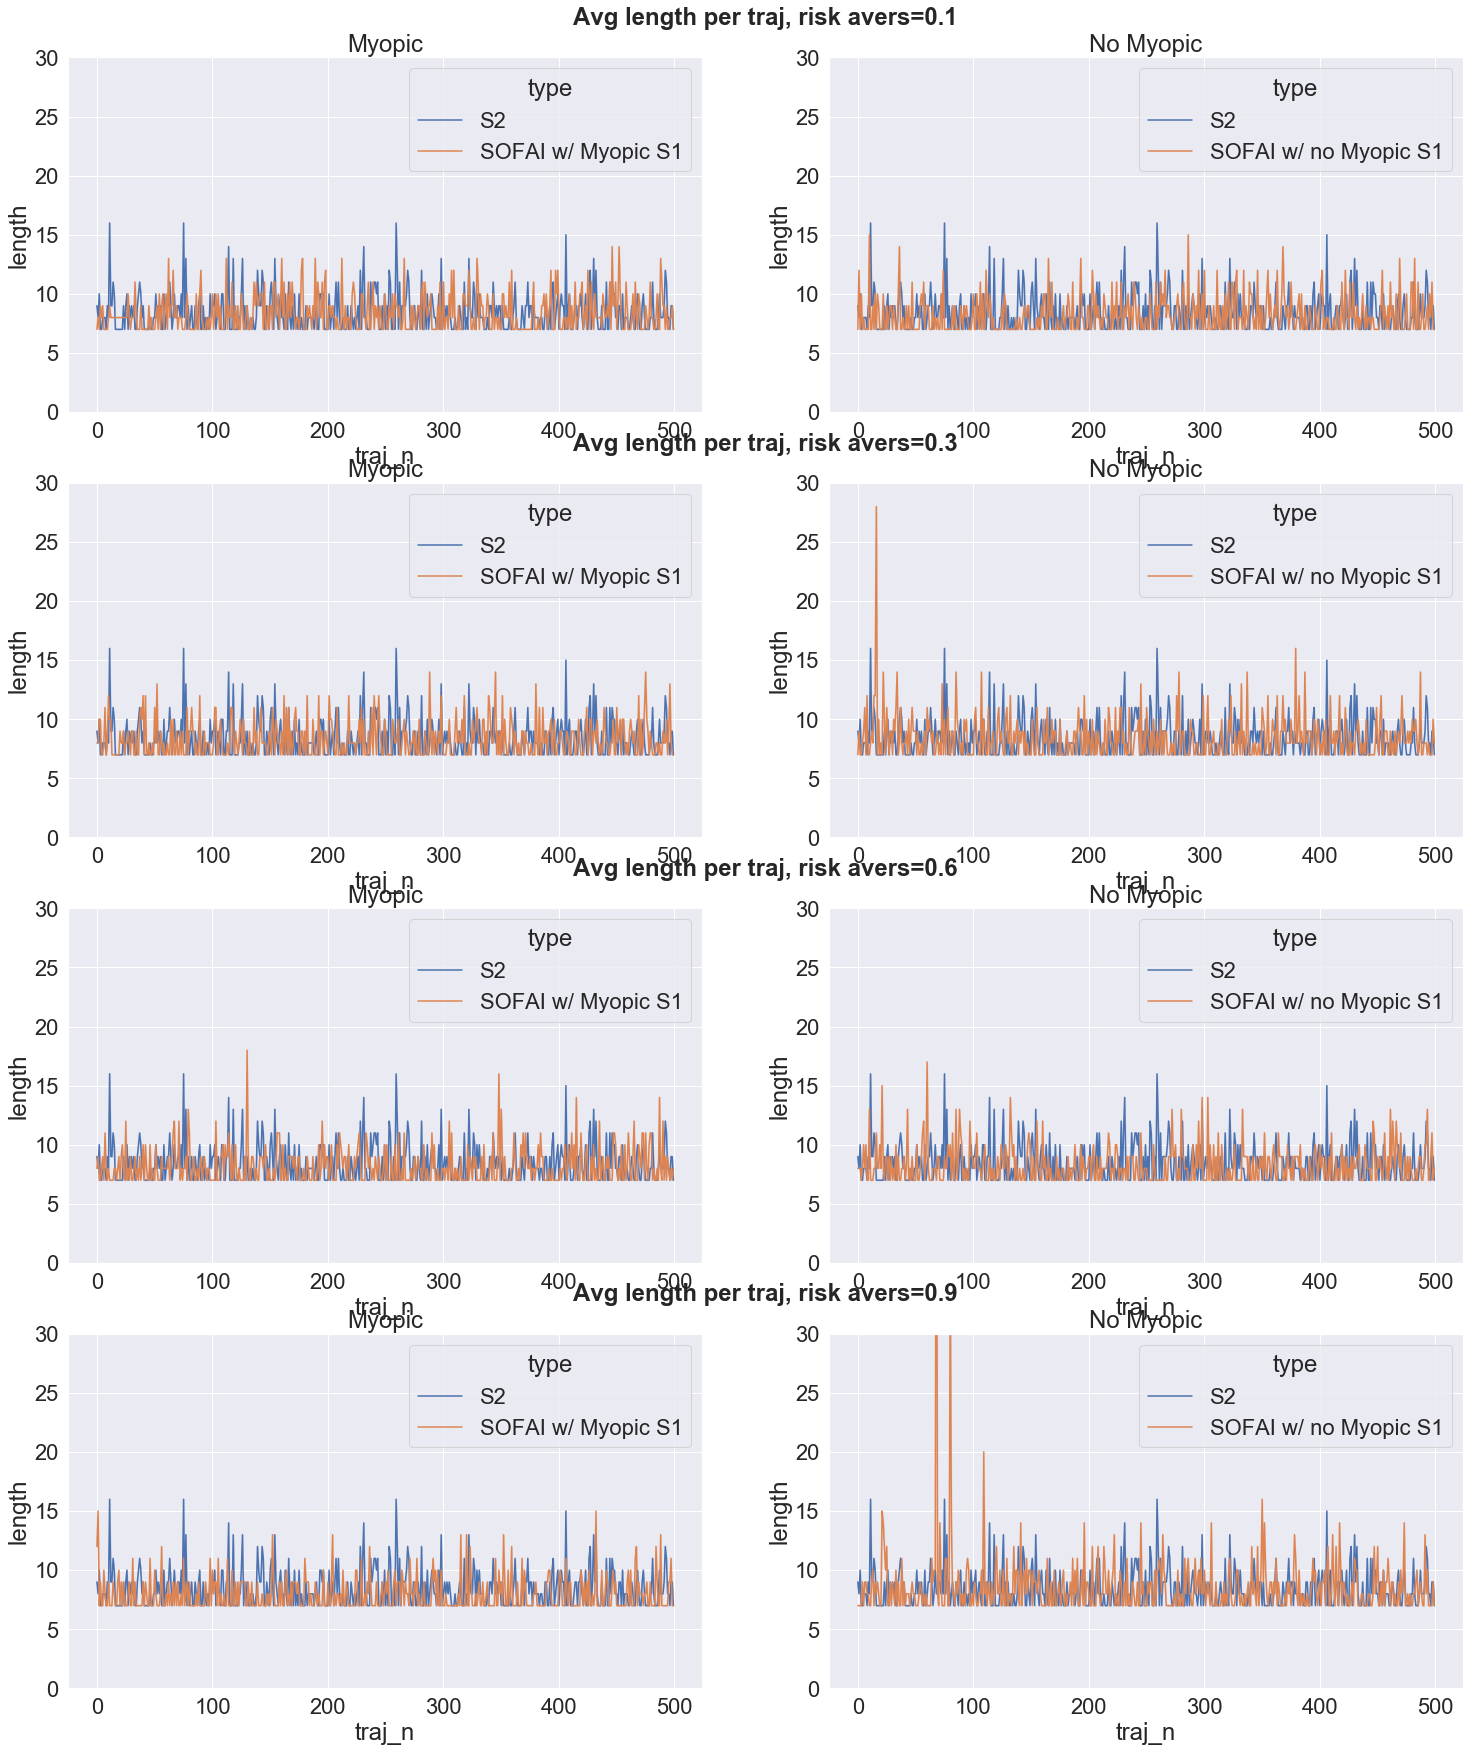

In [17]:
temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='length'

filename = 'avg_length_per_traj'
title="Avg length per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=30)

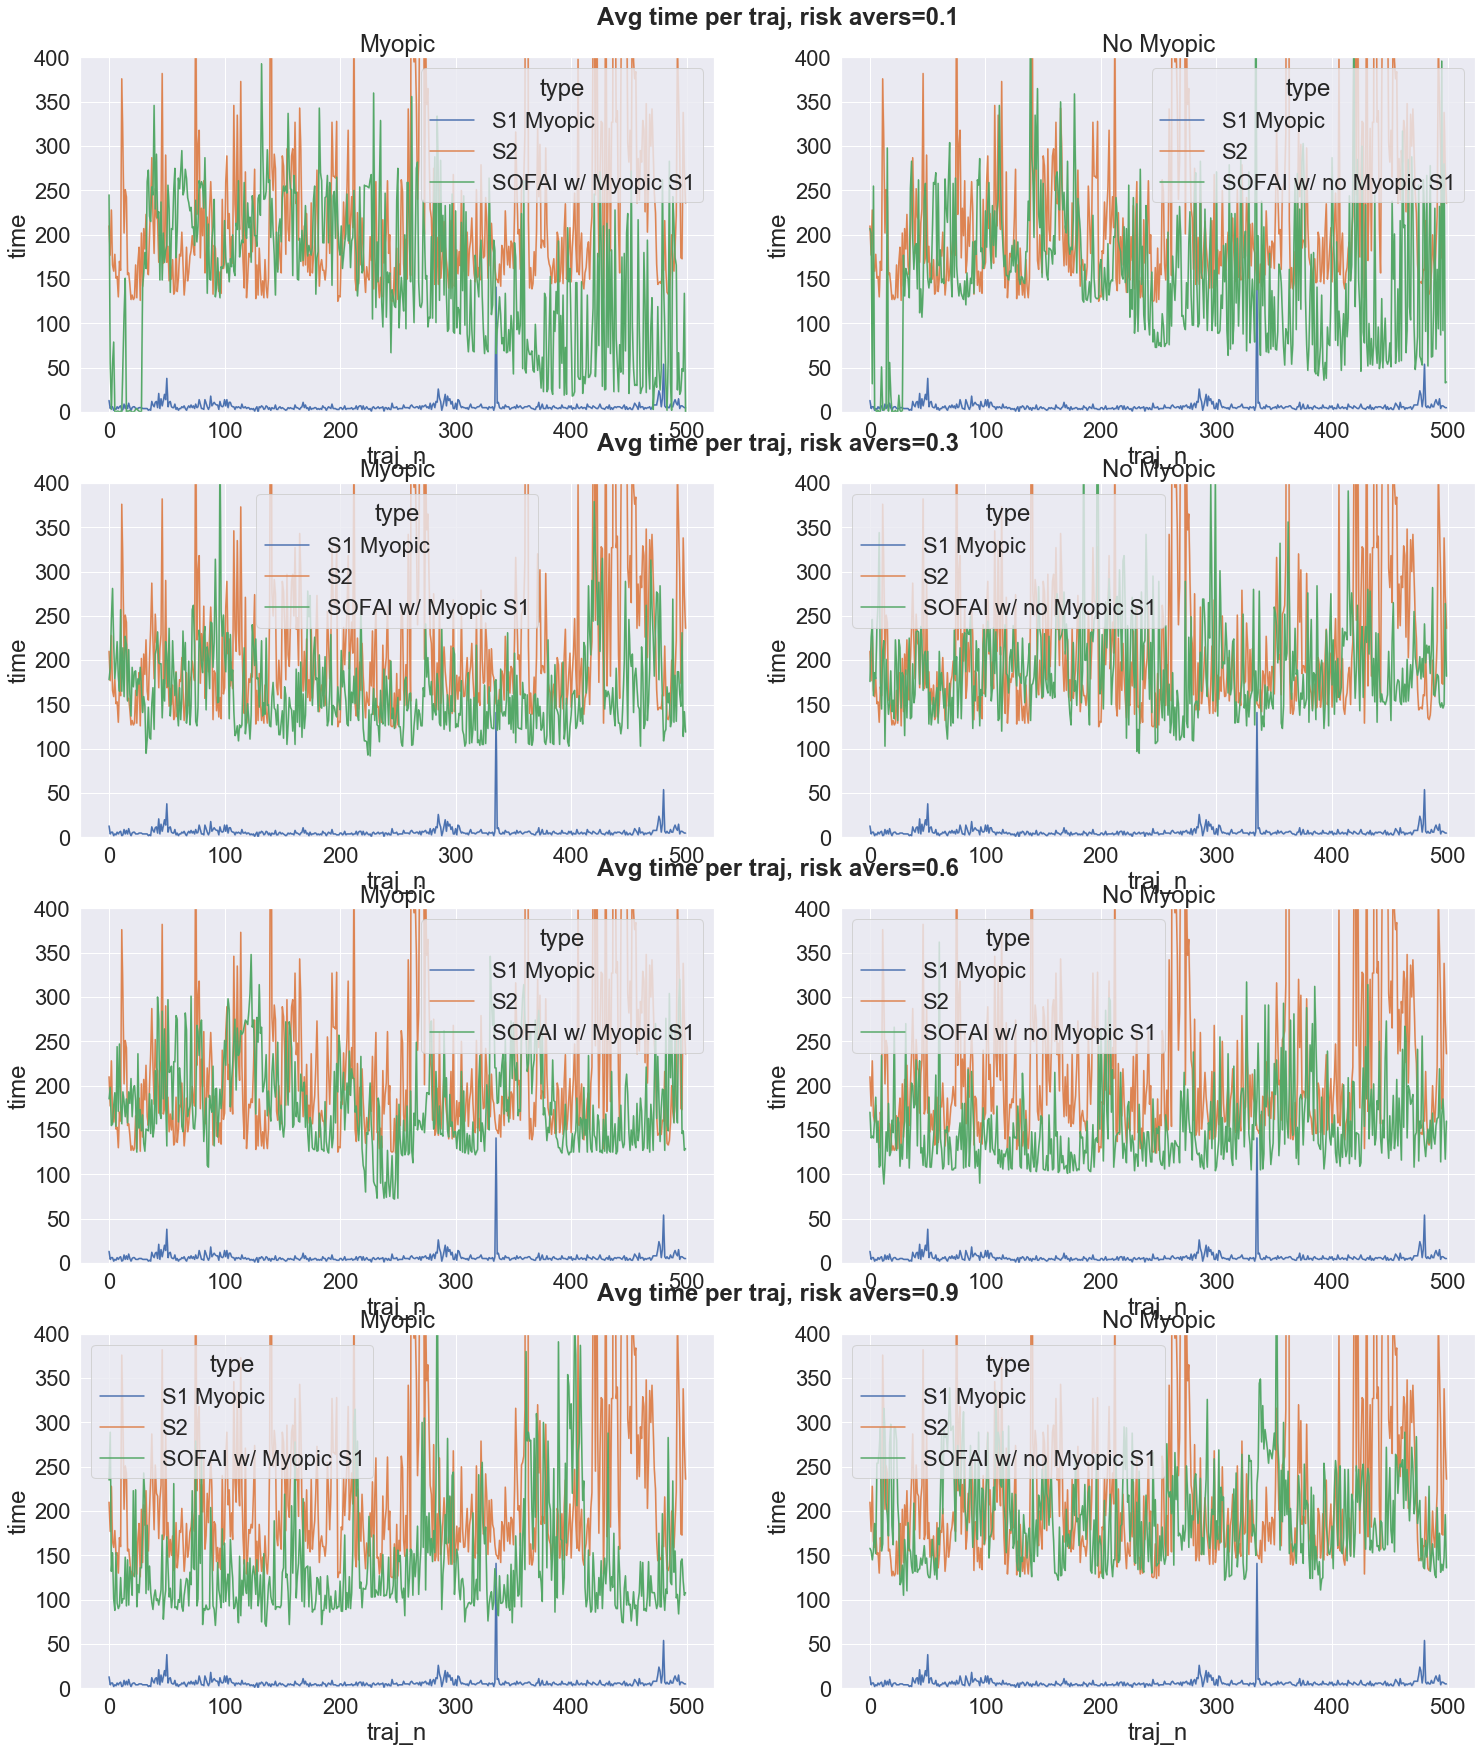

In [18]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')| (df['type']=='S1 Myopic')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='time'
filename = 'avg_time_withS1_per_traj'
title="Avg time per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=400)


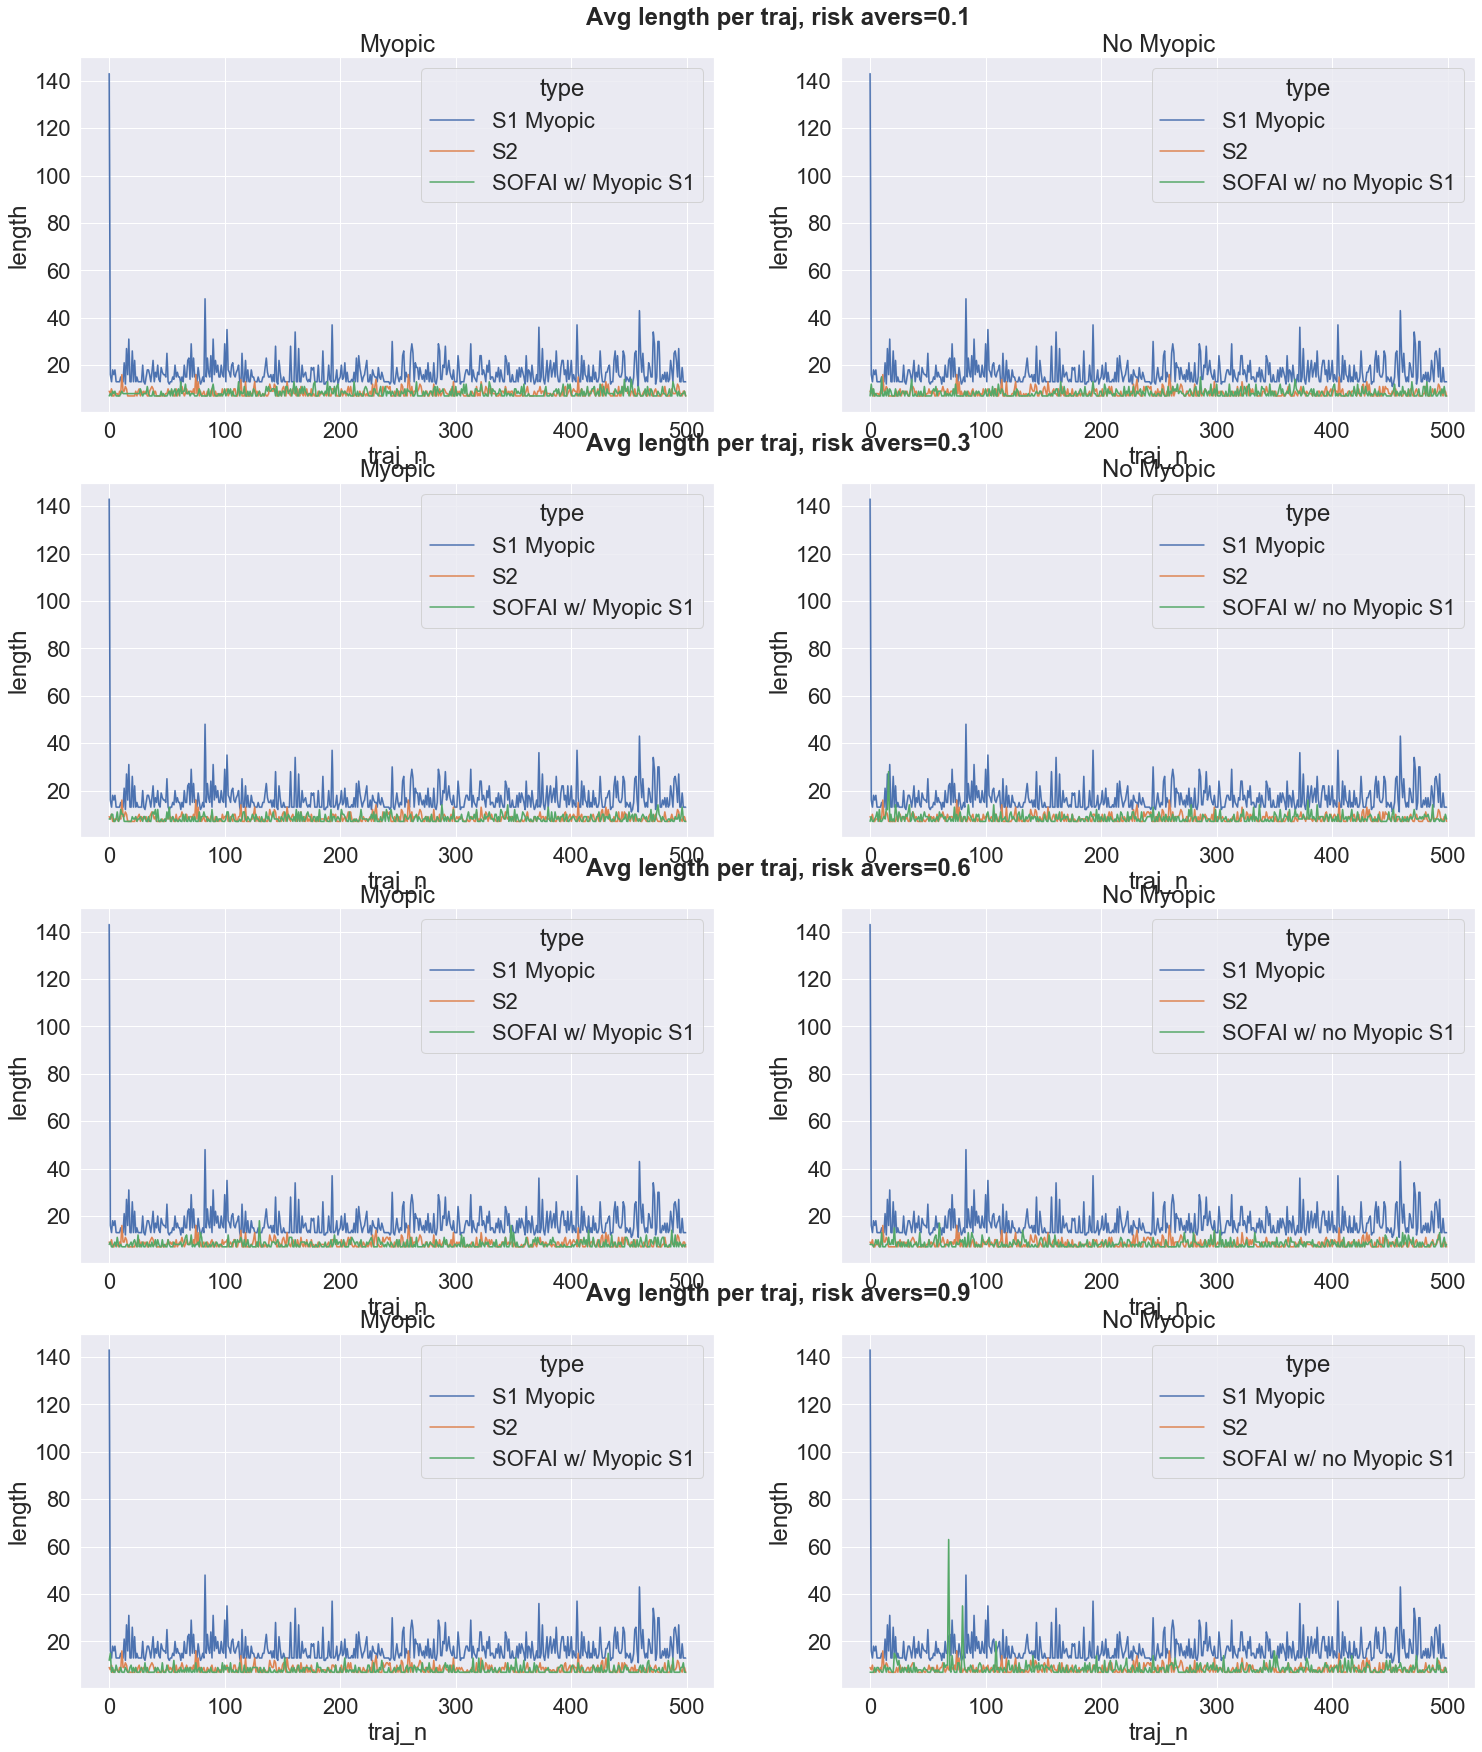

In [19]:
temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')| (df['type']=='S1 Myopic')| (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='length'
filename = 'avg_length_withS1_per_traj'
title="Avg length per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3)

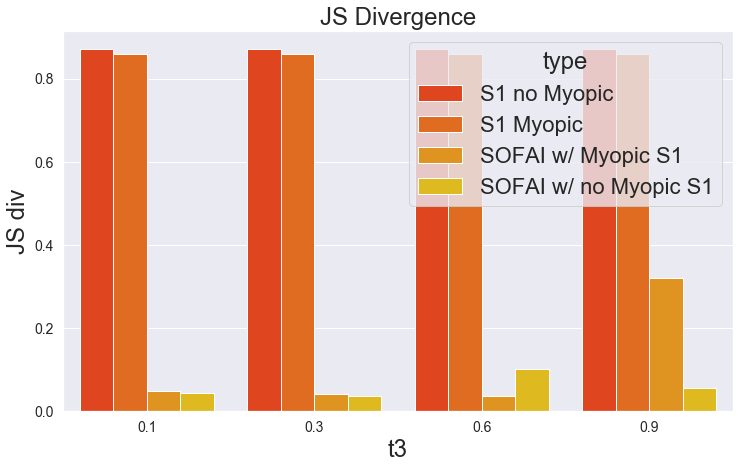

In [20]:
#js_div = pd.read_csv('remaining_time/same_grid/risk0.8/jsdiv_myopic_nomyopic_risk_0.8.csv')
#temp_df = js_div.loc[((js_div['t3']==threshold3) & (js_div['t4']==threshold4)) | (js_div['type']=='s1_nb')]
temp_df =js_div

y='jsdiv'


fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)
g = sns.barplot(x='t3', y=y, hue="type", data=temp_df, palette="autumn", ci=95);

h, l = g.get_legend_handles_labels()
#labels=['S1',"SOFAI 01","SOFAI 10","SOFAI 02"]
#g.legend(h, labels)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("t3")
plt.ylabel("JS div")
plt.title("JS Divergence")
plt.show()
fig.savefig(f"avg_js_dist.pdf", bbox_inches = 'tight') 

In [21]:
mca_01_myopic.__dict__

{'s1': <mc.system1.System1Solver at 0x140fd7f28>,
 's2': <mc.system2.System2Solver at 0x14427d160>,
 'modelSelf': <mc.self.ModelSelf at 0x14427d4e0>,
 'threshold1': 200,
 'threshold2': 0.95,
 'threshold3': 0.9,
 'threshold4': 200,
 'threshold5': 1,
 'threshold6': 1,
 'threshold7': 0.5,
 'usage_s1': 1201,
 'usage_s2': 2776,
 'time_usage_s2': 68819,
 'w': [0, 1],
 'trajectory_stat': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 1, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0],
  [1,

In [22]:
temp_dict


traj_n  length     reward  time sub_type  time_agent   avg_time  \
0         0       7 -26.284271   158       s1           0        NaN   
0         0       7 -26.284271   158       s2         158  22.571429   
1         1       7 -26.284271   155       s1           0        NaN   
1         1       7 -26.284271   155       s2         155  22.142857   
2         2       7 -26.284271   145       s1           0        NaN   
..      ...     ...        ...   ...      ...         ...        ...   
497     497       7 -26.284271   148       s2         148  21.142857   
498     498       9 -35.941125   196       s1           0        NaN   
498     498       9 -35.941125   196       s2         196  21.777778   
499     499       7 -26.284271   136       s1           0        NaN   
499     499       7 -26.284271   136       s2         136  19.428571   

     reward_agent  avg_reward  usage  ...  Length     Reward   Viol  S1_Usage  \
0        0.000000         NaN      0  ...    8.59 -37.652036  0.104         0   
0      -26.284271   -3.754896      7  ...    8.59 -37.652036  0.104         0   
1        0.000000         NaN      0  ...    8.59 -37.652036  0.104         0   
1      -26.284271   -3.754896      7  ...    8.59 -37.652036  0.104         0   
2        0.000000         NaN      0  ...    8.59 -37.652036  0.104         0   
..            ...         ...    ...  ...     ...        ...    ...       ...   
497    -26.284271   -3.754896      7  ...    8.59 -37.652036  0.104         0   
498      0.000000         NaN      0  ...    8.59 -37.652036  0.104         0   
498    -35.941125   -3.993458      9  ...    8.59 -37.652036  0.104         0   
499      0.000000         NaN      0  ...    8.59 -37.652036  0.104         0   
499    -26.284271   -3.754896      7  ...    8.59 -37.652036  0.104         0   

      t1   t2   t3  t4  t6   t7  
0    200  0.8  0.9   0   1  0.5  
0    200  0.8  0.9   0   1  0.5  
1    200  0.8  0.9   0   1  0.5  
1    200  0.8  0.9   0   1  0.5  
2    200  0.8  0.9   0   1  0.5  
..   ...  ...  ...  ..  ..  ...  
497  200  0.8  0.9   0   1  0.5  
498  200  0.8  0.9   0   1  0.5  
498  200  0.8  0.9   0   1  0.5  
499  200  0.8  0.9   0   1  0.5  
499  200  0.8  0.9   0   1  0.5  

[1000 rows x 22 columns]

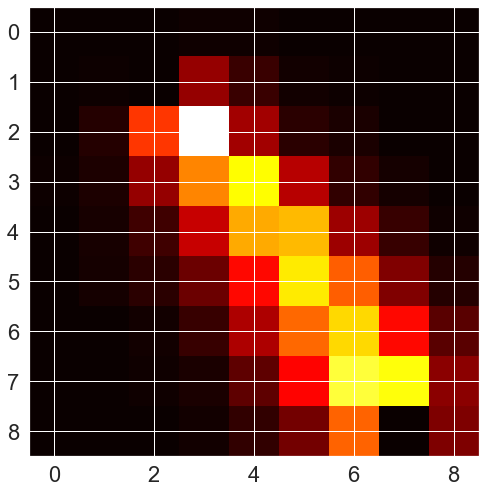

22

In [23]:
temp_matrix = count_states(demo_n.trajectories, n_cfg.mdp, n, constraints)

Z_distr = f(temp_matrix)
#print(int(start%9))
Z_distr[8-int(start/9)][int(start%9)]=0
Z_distr[8-int(goal/9)][int(goal%9)]

Z_distr = np.array(Z_distr)
Z_distr = Z_distr + 1E-3

plt.imshow(Z_distr/np.sum(Z_distr), cmap='hot', interpolation='nearest')
plt.show()

Z_distr/np.sum(Z_distr)
distr = np.array(Z_distr/np.sum(Z_distr))


np.random.choice(np.arange(0,81), replace=False, p = distr.flatten())

In [24]:
len(mca_01_noMyopic.modelSelf.s1_wrong_list)

359

In [25]:
m = [np.sum(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) / len(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_noMyopic.modelSelf.s1_wrong_list))]

In [27]:
m.reverse()

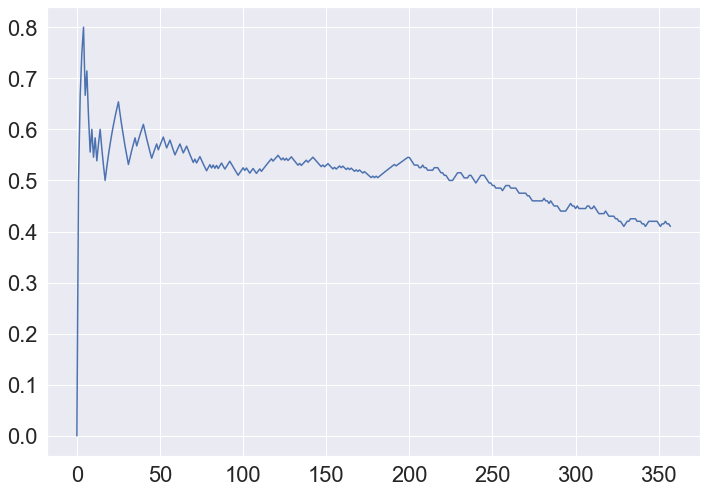

In [28]:
plt.plot(m)
plt.show()

In [30]:
m = [np.sum(mca_01_myopic.modelSelf.s1_wrong_list[-200-i:-i]) / len(mca_01_myopic.modelSelf.s1_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_myopic.modelSelf.s1_wrong_list))]

In [31]:
m.reverse()

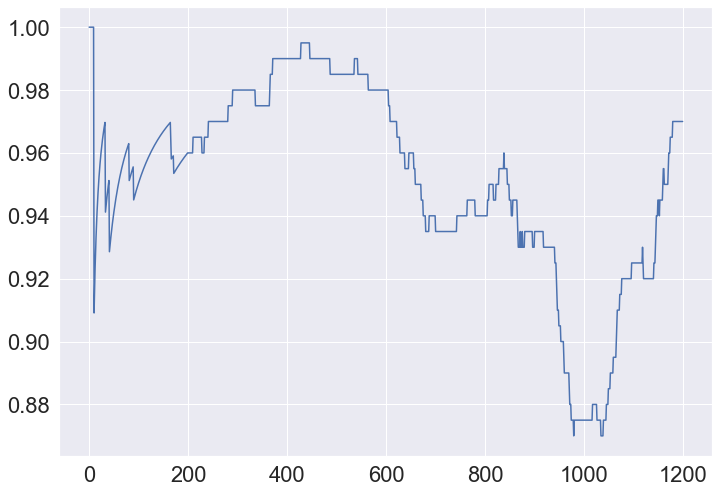

In [32]:
plt.plot(m)
plt.show()